In [1]:
#导入所需的库
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torch.optim as optim
import tenseal as ts
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
'''
FashionMNIST数据集
60000张训练图像和对应Label；
10000张测试图像和对应Label；
10个类别；
每张图像28x28的分辨率；
'''


#设置随机种子，确保每次训练结果一致
torch.manual_seed(22)

#训练集和测试集下载
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

#只取前500个测试数据
#test_data_subset = Subset(test_data, indices=range(500))
#test_loader = torch.utils.data.DataLoader(test_data_subset, batch_size=32, shuffle=True)

#加载训练集和测试集
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)


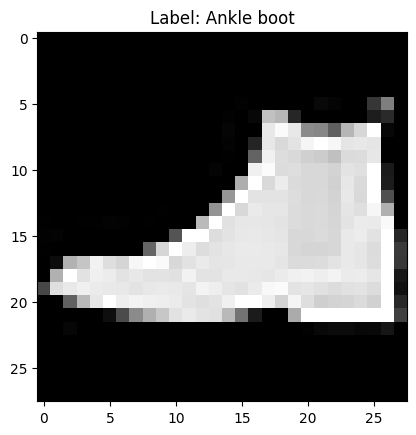

In [3]:


# 获取一批训练数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 定义类别名称
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 选择要查看的图像索引
img_index = 1

# 将图像从 Tensor 转换为 NumPy 以进行可视化
image = images[img_index].numpy()
image = np.transpose(image, (1, 2, 0))  # 将图像的维度从 (channels, height, width) 转换为 (height, width, channels)

# 显示图像和对应的标签
plt.figure()
plt.imshow(image.squeeze(), cmap='gray')  # 使用灰度图显示图像
plt.title('Label: ' + class_names[labels[img_index]])
plt.show()


In [5]:
#训练模型

#GPU加速

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#搭建神经网络
class FashionCNN(nn.Module):
    #初始化方法，搭建卷积层和全连接层
    def __init__(self,hidden=64,output=10):
        super(FashionCNN,self).__init__()
        self.conv=nn.Conv2d(in_channels=1,out_channels=4,kernel_size=7,padding=0,stride=3)
        self.fc1=nn.Linear(256,hidden)
        self.fc2=nn.Linear(hidden,output)
    #前向传播
    def forward(self,x):
        x=self.conv(x)
        x=x*x
        x=x.view(-1,256)
        x=self.fc1(x)
        x=x*x
        x=self.fc2(x)
        return x

#训练模型函数
def train(model,train_loader,criterion,optimizer,epochs=15):
    #将模型转为训练模式
    model.train()
    total_loss=0.0
    for epoch in range(epochs):
        train_loss=0.0
        start=time.time() #记录开始时间
        for train,target in train_loader:
            train, target = train.to(device), target.to(device)
            optimizer.zero_grad() #梯度清零
            output=model(train) #前向传播
            loss=criterion(output,target) #计算损失
            loss.backward() #反向传播
            optimizer.step() #更新参数
            train_loss+=loss.item() #总损失
        end=time.time()
        train_loss/=len(train_loader)
        print(f"epoch:{epoch+1} loss:{train_loss} time:{end-start}s")
    #模型转为评估模式
    model.train()

model=FashionCNN()
model=model.to(device)
criterion=nn.CrossEntropyLoss()
#optimizer=optim.SGD(model.parameters(),lr=0.001)
optimizer=optim.Adam(model.parameters(),lr=0.001)
train(model,train_loader,criterion,optimizer)


epoch:1 loss:0.6689242488384247 time:11.597928047180176s
epoch:2 loss:0.43223303662538526 time:11.802261352539062s
epoch:3 loss:0.3798349002202352 time:12.339439153671265s
epoch:4 loss:0.34741000193158783 time:12.29508090019226s
epoch:5 loss:0.32581202468474707 time:12.238223791122437s
epoch:6 loss:0.30956065028508506 time:12.319942235946655s
epoch:7 loss:0.29570278622905416 time:12.255208492279053s
epoch:8 loss:0.2841845334420601 time:12.262225151062012s
epoch:9 loss:0.27322715047895907 time:12.296542882919312s
epoch:10 loss:0.26328339286943275 time:12.248384475708008s
epoch:11 loss:0.2552214925934871 time:12.267890691757202s
epoch:12 loss:0.2471171918739875 time:12.271477699279785s
epoch:13 loss:0.24221290095150472 time:12.280086994171143s
epoch:14 loss:0.2350539436171452 time:12.244844675064087s
epoch:15 loss:0.22905471279968817 time:12.341521739959717s


In [6]:
# 保存整个模型
PATH = './Fashion_MNIST_Net.pth'
torch.save(model, PATH)

# 只保存模型权重
PATH = './Fashion_MNIST_WeightNet.pth'
torch.save(model.state_dict(), PATH)

In [7]:
#评估模型
def evaluate(model,criterion,test_loader):
    eval_loss=0.0
    class_total=list(0.0 for i in range(10))
    class_correct=list(0.0 for i in range(10))
    #评估模式
    model.eval()
    for data,target in test_loader:
        output=model(data)
        loss=criterion(output,target)
        eval_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct=np.squeeze(pred.eq(target.data.view_as(pred)))
        # 计算每个对象类别的测试准确率
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # 计算平均测试损失
    test_loss = eval_loss / len(test_loader)
    print(f'Test Loss: {test_loss:.6f}\n')

    # 打印每个类别的测试准确率
    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )

    # 打印整体测试准确率
    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% '
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )

# 加载模型
PATH = './Fashion_MNIST_Net.pth'
model = torch.load(PATH)
model=model.cpu()
# 调用测试函数
evaluate(model,criterion,test_loader)

Test Loss: 0.363907

Test Accuracy of 0: 81% (811/1000)
Test Accuracy of 1: 96% (966/1000)
Test Accuracy of 2: 77% (777/1000)
Test Accuracy of 3: 87% (875/1000)
Test Accuracy of 4: 84% (849/1000)
Test Accuracy of 5: 96% (966/1000)
Test Accuracy of 6: 69% (696/1000)
Test Accuracy of 7: 95% (955/1000)
Test Accuracy of 8: 96% (968/1000)
Test Accuracy of 9: 96% (960/1000)

Test Accuracy (Overall): 88% (8823/10000)


In [8]:
"""
It's a PyTorch-like model using operations implemented in TenSEAL.
    - .mm() method is doing the vector-matrix multiplication explained above.
    - you can use + operator to add a plain vector as a bias.
    - .conv2d_im2col() method is doing a single convolution operation.
    - .square_() just square the encrypted vector inplace.
"""

import tenseal as ts


class EncConvNet:
    def __init__(self, torch_nn):
        self.conv_weight = torch_nn.conv.weight.data.view(
            torch_nn.conv.out_channels, torch_nn.conv.kernel_size[0],
            torch_nn.conv.kernel_size[1]
        ).tolist()
        self.conv_bias = torch_nn.conv.bias.data.tolist()
        
        self.fc1_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()
        
        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()

        
    def forward(self, enc_x, windows_nb):
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv_weight, self.conv_bias):
            y = enc_x.conv2d_im2col(kernel, windows_nb) + bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        # square activation
        enc_x.square_()
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        # square activation
        enc_x.square_()
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    
def enc_test(context, enc_model, test_loader, criterion, kernel_shape, stride):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    n=0

    for data, target in test_loader:
        n += 1
        if n > 50:
            break
        t1 = time.time()
        # Encoding and encryption
        x_enc, windows_nb = ts.im2col_encoding(
            context, data.view(28, 28).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
        # Encrypted evaluation
        enc_output = enc_model(x_enc, windows_nb)
        # Decryption of result
        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)

        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1
        t2 = time.time()
        print("{} round time:{}s loss:{}".format(n, t2 - t1, loss.item()))


    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    for label in range(10):
        print(
            f'Test Accuracy of {label}: {int(100 * class_correct[label] / class_total[label])}% '
            f'({int(np.sum(class_correct[label]))}/{int(np.sum(class_total[label]))})'
        )

    print(
        f'\nTest Accuracy (Overall): {int(100 * np.sum(class_correct) / np.sum(class_total))}% ' 
        f'({int(np.sum(class_correct))}/{int(np.sum(class_total))})'
    )


# Load one element at a time
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
# required for encoding
kernel_shape = model.conv.kernel_size
stride = model.conv.stride[0]


In [9]:
'''
Choosing the parameters isn't easy, so we list some intuition here for why we have chosen these parameters exactly:

1. For a given security level (e.g. 128-bits security) and a polynomial modulus degree (e.g. 8192) there is an upper bound for the bit count of the coefficient modulus (`sum(coeff_mod_bit_sizes)`). If the upper bound is surpassed, there is a need to use a higher polynomial modulus degree (e.g. 16384) in order to make sure we still have the required security level.
2. The multiplicative depth is controlled by the number of primes constituting our coefficient modulus.
3. All elements of `coeff_mod_bit_sizes[1: -1]` should be equal in TenSEAL, since it takes care of rescaling ciphertexts. And we also want to use the same number of bits (e.g. 2 ^ 26) for the scale during encryption.
4. The scale is what controls the precision of the fractional part, since it's the value that plaintexts are multiplied with before being encoded into a polynomial of integer coefficients.

Starting with a scale of more than 20 bits, we need to choose the number of bits of all the middle primes equal to that, so we are already over 120 bits. With this lower bound of coefficient modulus and a security level of 128-bits, we will need a polynomial modulus degree of at least 8192. The upper bound for choosing a higher degree is at 218. Trying different values for the precision and adjusting the coefficient modulus, while studying the loss and accuracy, we end up with 26-bits of scale and primes. We also have 5 bits (31 - 26) for the integer part in the last coefficient modulus, which should be enough for our use case, since output values aren't that big.
'''

## Encryption Parameters

# controls precision of the fractional part
bits_scale = 26

# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31,  bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

# set the scale
context.global_scale = pow(2, bits_scale)

# galois keys are required to do ciphertext rotations
context.generate_galois_keys()
#This will now run encrypted evaluation over the whole test-set. It's gonna take time, but with this, you can feel proud of having done encrypted inference on a test-set of 10000 elements, congratulations!
start=time.time()
enc_model = EncConvNet(model)
enc_test(context, enc_model, test_loader, criterion, kernel_shape, stride)
end=time.time()
print(f"运行了{end-start}s")

1 round time:2.9820785522460938s loss:1.5258672647178173e-05
2 round time:1.7309787273406982s loss:0.048512835055589676
3 round time:1.97397780418396s loss:0.15996915102005005
4 round time:1.710634708404541s loss:0.0
5 round time:1.8900644779205322s loss:4.768370445162873e-07
6 round time:1.5064258575439453s loss:1.1920928244535389e-07
7 round time:1.5699453353881836s loss:0.0
8 round time:1.7279143333435059s loss:1.3245081901550293
9 round time:1.6866967678070068s loss:7.748303323751315e-05
10 round time:1.5928080081939697s loss:0.0
11 round time:1.5796494483947754s loss:0.021376801654696465
12 round time:3.025085210800171s loss:0.035290058702230453
13 round time:1.6985280513763428s loss:0.0
14 round time:1.6984548568725586s loss:0.0030074152164161205
15 round time:1.8034744262695312s loss:0.6376487612724304
16 round time:1.7850100994110107s loss:0.11526205390691757
17 round time:1.8102176189422607s loss:0.0
18 round time:1.7917511463165283s loss:0.022516077384352684
19 round time:1.9